This notebook will go through basic concepts of a regular work flow of NLP. 
In this particular example, we will be using Ski-kit learn Complement Naive bayer model and SVC model to performance a multilabel classfication on 14 different YWCA report's labels.
Keep in mind our data sets will contiue to be updated, so we may adjust models and other codes accordingly

In [1]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


Loading dependancies for sci-kit learn, NLTK, and other basic utility python library

Display the sci-kit learn and NLTK versions.
 

In [2]:
import os, re
import gensim
import sklearn
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix,classification_report
from sklearn.utils.class_weight import compute_sample_weight


import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

print(f"NLTK's version is {nltk.__version__} , Sci-kit learn's version is {sklearn.__version__}")

NLTK's version is 3.2.5 , Sci-kit learn's version is 0.23.2


Download the NLTK punctuation pkg, stopwords pkg, wordnet pkg 

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

upload data-prcoessed.csv from local. This data-processed file is the output of current (before Aug 5th,2020) git main branch.


In [4]:
from google.colab import files
uploaded = files.upload()

Saving data-processed.csv to data-processed (1).csv


Read file by pandas. assign variable to target documents to be processed.
Display the first 5 samples.

In [5]:
yw_df = pd.read_csv("data-processed.csv")
yw_clean = yw_df["DESCRIPTION"]
yw_clean.head()

0    staff could hear ** make loud yelling noise fr...
1    this afternoon ** arrive at the building with ...
2    at approximately 1015pm ** enter building and ...
3    * be do shift exchange with staff when ** fell...
4    client ***** come into 417 at around 10pm ** b...
Name: DESCRIPTION, dtype: object

Standard NLTK tokenizer:
1.This remove stopwords and anything is not letters(words). 
2. Lemmatization is applied and wordnet lemmatizer is used. Snowball lemmatizer is a good alternative I can explore further later to compare and it also support built in stop word removal so code can be more elegant.
3. word are in its lower form
4. return a list of tokens => we can change to pandas dataframe but for illustration purpose, it should have the same output.

In [6]:
def nltk_tokenizer(df_sent):
    lemmatizer = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    tokens = word_tokenize(df_sent)
    words = [word.lower() for word in tokens if word.isalpha()]  # get rid of puntuation
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]

    return words


Instead of a binary encoding in list comprehension. In here, I used sci-kit learn labelencoder to label the 14 catgories. The full information has been displayed in output.

In [7]:
encoder = LabelEncoder()
yw_txt_cats = encoder.fit_transform([t for t in yw_df['INCIDENT_TYPE_1']])

Function: count_weight

*   take in a partial files or total files
*   return a dictionary with all the count, as you can see later some label will be zero count in the test set



In [8]:
def count_weight(categories,total_files = yw_txt_cats):
  weight_dict = {lb:0 for lb in list(set(yw_txt_cats))}
  for cat in categories:
      weight_dict[cat] += 1 
   
  return weight_dict

****** Weights distribution based on sample count for our data by labels

In [9]:
print("Total data set counts: {} \n".format(len(yw_txt_cats)))
weights_dict = count_weight(yw_txt_cats)
for i, cls in enumerate(encoder.classes_):
  print('{}. {} weights is : {:.2%} with count : {}\n'.format(i,cls,weights_dict[i]/len(yw_txt_cats),weights_dict[i]))

Total data set counts: 335 

0. Client aggression towards another person weights is : 11.34% with count : 38

1. Client aggression towards property weights is : 0.90% with count : 3

2. Client death (onsite) weights is : 0.90% with count : 3

3. Concern for welfare of a child weights is : 4.48% with count : 15

4. Homicide (Threat or attempt) weights is : 0.30% with count : 1

5. Illegal activity on premises weights is : 0.30% with count : 1

6. Injury weights is : 2.69% with count : 9

7. Medical emergency weights is : 46.87% with count : 157

8. Mental health emergency weights is : 5.97% with count : 20

9. Other weights is : 12.84% with count : 43

10. Security concern weights is : 4.78% with count : 16

11. Suicide attempt weights is : 2.99% with count : 10

12. Suspicion/allegation of abuse towards or against client weights is : 3.88% with count : 13

13. nan weights is : 1.79% with count : 6



I have tried both count vector and tfidf vector as I said in the meeting. The outcomes is Tfidf vector offer is marginal better result than count vector.

In [10]:
word_vec = TfidfVectorizer(tokenizer=nltk_tokenizer,
                                          token_pattern=r'\b\w+\b',
                                          ngram_range=(1, 2),
                                          min_df=2)
yw_clean = word_vec.fit_transform(yw_clean)

Split the data into train and test same way as CNB model in Cal's branch. I think we should also consider random setting to 0 to 42 and see how much our evaluation varies. I found if we set random state proper at 32 we can reach 77% accuracy, but if we dont set random_state. the accuracy change each time you rerun this cell and next cell together. 

Currently this notebook outputs showing at optimized accuracy score. you can experiement around to verify what I mean by removing random_state setting or change its value, then run the score cell after

Also, weights split has been set with same hyperparameters with train and test split for train and test sets

In [11]:
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(
                                        yw_clean, 
                                        yw_txt_cats,
                                        train_size=0.75,
                                        random_state = 32,
                                        shuffle = True)

weight_load = compute_sample_weight(weights_dict,yw_txt_cats)
weight_train,weight_test = train_test_split(
                                        weight_load,
                                        train_size=0.75,
                                        random_state = 32,
                                        shuffle = True)


train and score: accuracy score


In [12]:
cnb = ComplementNB()

cnb.fit(X_train_set,y_train_set,sample_weight = weight_train)
score_train = cnb.score(X_test_set, y_test_set,weight_test)
print("Accuracy score on test set is {0:.2f}".format(score_train))

Accuracy score on test set is 0.76


SVC perform better on test set based on accuracy matrix.

In [13]:
svm = SVC()
svm.fit(X_train_set,y_train_set,sample_weight = weight_train)
score_train = svm.score(X_test_set, y_test_set,weight_test)
print("Accuracy score on test set is {0:.2f}".format(score_train))

Accuracy score on test set is 0.92


*****Cross-Validation: We show what is the scores on train set with k = 5-fold to default. This is why we have 5 scores produced because 5 fold will provide 5 different validation sets

Here we run a basic validation. I will update more in the parameter to explore other evaluation matrix or settings

We also introduce a new matric for measuring cross-validation on our train set: balanced accuracy score.




In [14]:
scorer = make_scorer(balanced_accuracy_score)
cv_ = cross_validate(cnb,
                     X = X_train_set,
                     y = y_train_set,
                     scoring = ["balanced_accuracy","accuracy"],
                     fit_params={'sample_weight': weight_train}
                      )

print("String keys for cross-validation {}".format(cv_.keys()))
print("Complement NB accuracy scores on 5-fold cross-validation: {}".format(cv_["test_accuracy"]))
print("Complement NB balanced accuracy scores on 5-fold cross-validation: {}".format(cv_["test_balanced_accuracy"]))

String keys for cross-validation dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'test_accuracy'])
Complement NB accuracy scores on 5-fold cross-validation: [0.45098039 0.46       0.5        0.58       0.5       ]
Complement NB balanced accuracy scores on 5-fold cross-validation: [0.31306572 0.29272727 0.29515939 0.40161354 0.21526958]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [15]:
cv_ = cross_validate(svm,
                     X = X_train_set,
                     y = y_train_set,
                     scoring = ["balanced_accuracy","accuracy"],
                     fit_params={'sample_weight': weight_train}
                      )

print("SVM Accuracy scores on 5-fold cross-validation: {}".format(cv_["test_accuracy"]))
print("SVM Balanced accuracy scores on 5-fold cross-validation: {}".format(cv_["test_balanced_accuracy"]))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


SVM Accuracy scores on 5-fold cross-validation: [0.45098039 0.52       0.48       0.5        0.5       ]
SVM Balanced accuracy scores on 5-fold cross-validation: [0.18181818 0.23333333 0.1257379  0.20779221 0.13203463]


More clean look on Complment NB model accuracy and balance accuracy with adjusted weights setting on both train and test set

In [16]:
predicted_test = cnb.predict(X_test_set)
test_score = accuracy_score(y_test_set,predicted_test,sample_weight=weight_test)
predicted_train = cnb.predict(X_train_set)
train_score = accuracy_score(y_train_set,predicted_train,sample_weight=weight_train)

predicted_btest = cnb.predict(X_test_set)
test_balance = balanced_accuracy_score(y_test_set,predicted_btest,sample_weight=weight_test)
predicted_btrain = cnb.predict(X_train_set)
train_balance = balanced_accuracy_score(y_train_set,predicted_btrain,sample_weight=weight_train)

print("complment NB test accuracy score is :{:.2%} \n".format(test_score))
print("complment NB train accuracy score is :{:.2%} \n".format(train_score))
print("complment NB test balance accuracy score is :{:.2%} \n".format(test_balance))
print("complment NB train balance accuracy score is :{:.2%} \n".format(train_balance))

complment NB test accuracy score is :75.77% 

complment NB train accuracy score is :98.00% 

complment NB test balance accuracy score is :31.90% 

complment NB train balance accuracy score is :70.03% 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


C-Support Vector Classification (SVC) model has some advantage over and consistency on training set on both evaluation matrix. As our test set are short for classes due to shortage of data, I think SVC maybe a better choice here. There are also open tree classifer and SGDC boost, which I experiment more as well 

In [17]:
predicted_test = svm.predict(X_test_set)
test_score = accuracy_score(y_test_set,predicted_test,sample_weight=weight_test)
predicted_train = svm.predict(X_train_set)
train_score = accuracy_score(y_train_set,predicted_train,sample_weight=weight_train)

predicted_btest = svm.predict(X_test_set)
test_balance = balanced_accuracy_score(y_test_set,predicted_btest,sample_weight=weight_test)
predicted_btrain = svm.predict(X_train_set)
train_balance = balanced_accuracy_score(y_train_set,predicted_btrain,sample_weight=weight_train)

print("SVM-C test accuracy score is :{:.2%} \n".format(test_score))
print("SVM-C train accuracy score is :{:.2%} \n".format(train_score))
print("SVM-C test balance accuracy score is :{:.2%} \n".format(test_balance))
print("SVMC-C train balance accuracy score is :{:.2%} \n".format(train_balance))

SVM-C test accuracy score is :92.13% 

SVM-C train accuracy score is :99.81% 

SVM-C test balance accuracy score is :22.22% 

SVMC-C train balance accuracy score is :92.04% 



Bar chart shows how the data is distributed based on frequency. The array are name of catgories are  < 5 incidents. This is important because our cross-validation default to 5.

array(['Client aggression towards property', 'Client death (onsite)',
       'Homicide (Threat or attempt)', 'Illegal activity on premises'],
      dtype='<U55')

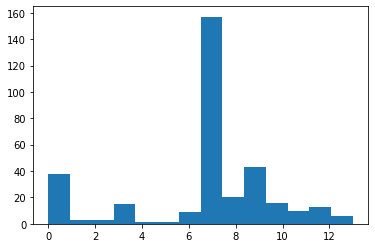

In [18]:

plt.hist(yw_txt_cats,bins = 14)

encoder.inverse_transform([1,2,4,5])

To go back our issue on different distribution between train set and test set. We can see train set has all the label classes, but test set has shorted 2 classes. Keep in mind we also set our random_state at 32 and manually optimized the result. The accuracy can drop to 58% with a different random_state settting from my experience 

In [19]:
set(y_train_set)


{0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13}

In [20]:
set(y_test_set)

{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12}

**********Cross validation + params tuning process*************

>  Here is the block code to illustrate GridSearchCV. The purpose of gridsearch is hyperparameter fine tuning and cross-validate with cross-validation set ( in here, we have another minor problem to consider. As per Andrew N ML course, cross-validation should be similiar size as test set and different from train set). We use training set as both train and cross-validate. With very limited data right now I suggest we keep as only train and test as I have seen most practice out there only consider these type of split.

> Another purpose of GridSearch is we can set number of n-folds in parameter and it will performance stratified kfold by default, still need to find out more on setting weight with gridsearch



In [21]:
# accuracy score feedback
param_grid = {'alpha':np.logspace(-5,0,6)
              }
grid = GridSearchCV(
    cnb,
    param_grid,
    cv =5
    )

grid.fit(X_train_set,y_train_set)
print("grid best score cross validation at {:.2%}".format(grid.best_score_))
print("best grid parameters are :{}".format(grid.best_params_))


grid best score cross validation at 60.17%
best grid parameters are :{'alpha': 1.0}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [22]:
# balanced accuracy score feedback
param_grid = {'alpha':np.logspace(-5,0,6),
              }
print("Hyper-parameters for complementNB model are :")
print(cnb.get_params().keys())
grid = GridSearchCV(cnb,param_grid,scoring = scorer,cv =5)
grid.fit(X_train_set,y_train_set)
print("grid best score cross validation at {:.2%}".format(grid.best_score_))
print("best grid parameters are :{}".format(grid.best_params_))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dis

Hyper-parameters for complementNB model are :
dict_keys(['alpha', 'class_prior', 'fit_prior', 'norm'])
grid best score cross validation at 38.02%
best grid parameters are :{'alpha': 1.0}


*******************Confusion matrix********************

> display the array of TP(true postive),FN (false negative),FP (false positive),TN(true negative) outcomes in counts or percentage.






Training set based on Complment NB model

Plot confusion matrix

Text(0.5, 1.0, 'Confusition matrix on train set with normalization')

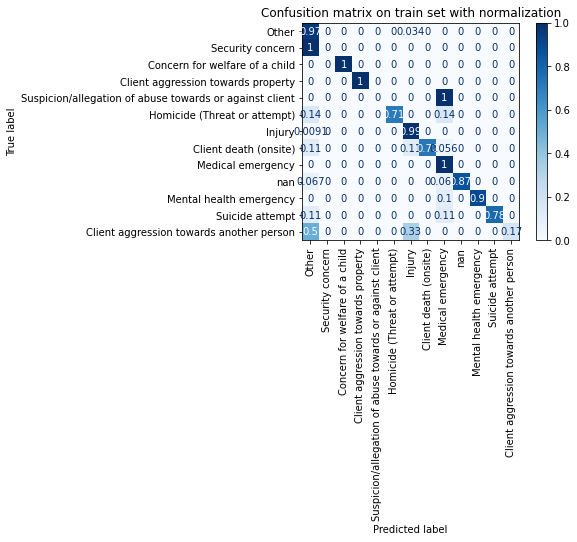

In [80]:
train_class = list(set(true_train))
disp = plot_confusion_matrix(cnb, 
                             X_train_set,
                             y_train_set,
                             sample_weight=weight_train,
                             normalize='true',
                             display_labels= train_class,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical'
                            )
title = "Confusition matrix on train set with normalization"
disp.ax_.set_title(title)




Test set confusion matrix based on Complement NB model

Text(0.5, 1.0, 'Confusition matrix on test set with normalization')

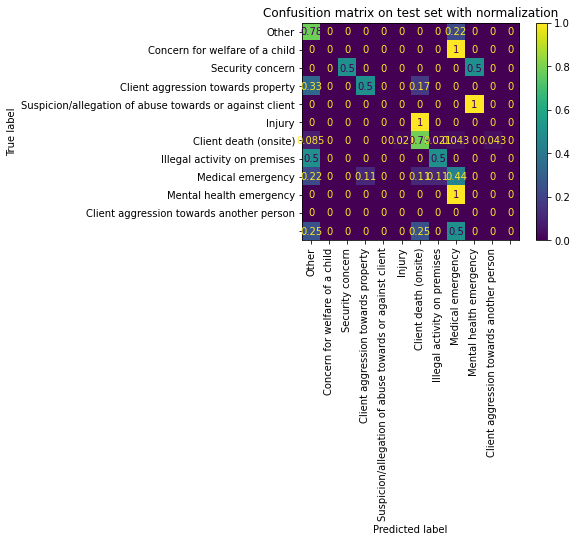

In [81]:

test_class = list(set(true_test))

disp = plot_confusion_matrix(cnb, 
                             X_test_set,
                             y_test_set,
                             sample_weight=weight_test,
                             normalize='true',
                             display_labels= test_class,
                             xticks_rotation='vertical'
                            )
title = "Confusition matrix on test set with normalization"
disp.ax_.set_title(title)

SVM model on train set confusion matrix display

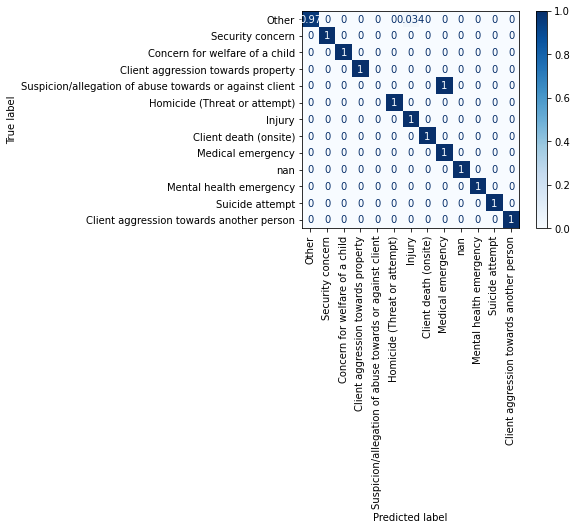

In [79]:
disp = plot_confusion_matrix(svm, 
                             X_train_set,
                             y_train_set,
                             sample_weight=weight_train,
                             normalize='true',
                             display_labels=train_class,
                             cmap=plt.cm.Blues,
                             xticks_rotation = "vertical"
                            )



Text(0.5, 1.0, 'Confusition matrix on test set with normalization')

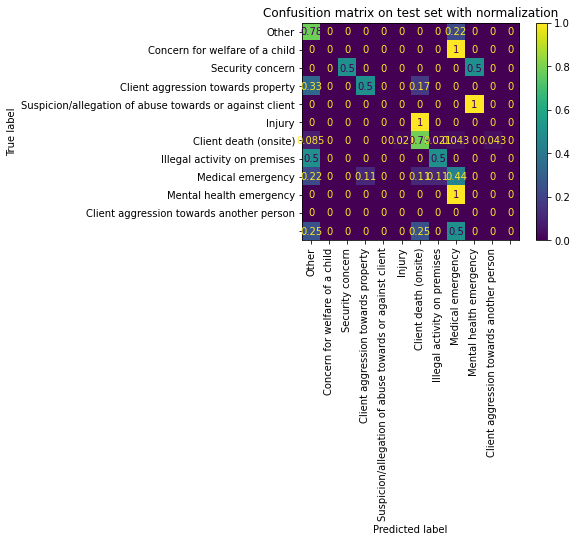

In [78]:
disp = plot_confusion_matrix(cnb, 
                             X_test_set,
                             y_test_set,
                             sample_weight=weight_test,
                             normalize='true',
                             display_labels= test_class,
                             xticks_rotation = 'vertical'
                          
                            )
title = "Confusition matrix on test set with normalization"
disp.ax_.set_title(title)

Classfication reports:


1.   precision:
2.   recall:
3.   f1-score:
4.   support:



In [75]:
predicted_train = [encoder.inverse_transform([cat])[0] for cat  in cnb.predict(X_train_set)]
true_train = [encoder.inverse_transform([cat])[0] for cat in y_train_set]
print("Complment NB train set classfication report\n")
print(classification_report(true_train,predicted_train, sample_weight = weight_train,labels=encoder.classes_ ,target_names = encoder.classes_))

Complment NB train set classfication report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       0.80      0.97      0.88    1102.0
                     Client aggression towards property       0.00      0.00      0.00       6.0
                                  Client death (onsite)       1.00      1.00      1.00       3.0
                         Concern for welfare of a child       1.00      1.00      1.00     135.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       1.0
                           Illegal activity on premises       0.00      0.00      0.00       0.0
                                                 Injury       1.00      0.71      0.83      63.0
                                      Medical emergency       0.99      0.99      0.99   17270.0
                                Mental health emergency       1.00      0.72     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
predicted_train = [encoder.inverse_transform([cat])[0] for cat  in svm.predict(X_train_set)]
true_train = [encoder.inverse_transform([cat])[0] for cat in y_train_set]
print("SVM-C model train set classfication report\n")
print(classification_report(true_train,predicted_train, sample_weight = weight_train,labels=encoder.classes_ ,target_names = encoder.classes_))

SVM-C model train set classfication report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       1.00      0.97      0.98    1102.0
                     Client aggression towards property       1.00      1.00      1.00       6.0
                                  Client death (onsite)       1.00      1.00      1.00       3.0
                         Concern for welfare of a child       1.00      1.00      1.00     135.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       1.0
                           Illegal activity on premises       0.00      0.00      0.00       0.0
                                                 Injury       1.00      1.00      1.00      63.0
                                      Medical emergency       1.00      1.00      1.00   17270.0
                                Mental health emergency       1.00      1.00      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
predicted_test = [encoder.inverse_transform([cat])[0] for cat  in cnb.predict(X_test_set)]
true_test = [encoder.inverse_transform([cat])[0] for cat in y_test_set]
print("ComplmentNB test set classfication report\n")
print(classification_report(true_test,predicted_test,sample_weight = weight_test,labels=encoder.classes_ ,target_names = encoder.classes_))

ComplmentNB test set classfication report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       0.26      0.78      0.38     342.0
                     Client aggression towards property       0.00      0.00      0.00       3.0
                                  Client death (onsite)       1.00      0.50      0.67       6.0
                         Concern for welfare of a child       0.51      0.50      0.51      90.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                           Illegal activity on premises       0.00      0.00      0.00       1.0
                                                 Injury       0.00      0.00      0.00      18.0
                                      Medical emergency       0.98      0.79      0.88    7379.0
                                Mental health emergency       0.09      0.50      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
predicted_test = [encoder.inverse_transform([cat])[0] for cat  in svm.predict(X_test_set)]
true_test = [encoder.inverse_transform([cat])[0] for cat in y_test_set]
print("SVM-C test set classfication report\n")
print(classification_report(true_test,predicted_test,sample_weight = weight_test,labels=encoder.classes_ ,target_names = encoder.classes_))

SVM-C test set classfication report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       0.72      0.44      0.55     342.0
                     Client aggression towards property       0.00      0.00      0.00       3.0
                                  Client death (onsite)       1.00      0.50      0.67       6.0
                         Concern for welfare of a child       1.00      0.17      0.29      90.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                           Illegal activity on premises       0.00      0.00      0.00       1.0
                                                 Injury       0.00      0.00      0.00      18.0
                                      Medical emergency       0.93      1.00      0.96    7379.0
                                Mental health emergency       0.00      0.00      0.00   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Saving model

In [82]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')
model_save_name = 'cnb.pickle' # file format for sci-kit
path = F"/content/gdrive/My Drive/{model_save_name}" 
pickle.dump(cnb, open(path, 'wb'))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [84]:
loaded_model = pickle.load(open(path, 'rb'))
loaded_model.score(X_test_set,y_test_set,sample_weight=weight_test)

0.7577393808495321